# QAOA 

In [1]:
from qiskit_aer import AerSimulator
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import QAOAAnsatz
from qiskit_ibm_runtime import QiskitRuntimeService, Session, EstimatorV2 as Estimator, SamplerV2 as Sampler
from scipy.optimize import minimize
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

## Explanation:

QAOA is a quantum algorithm designed to solve combinatorial optimization problems, such as the Max-Cut problem. It encodes the problem into a cost Hamiltonian $H_C$, where the ground state represents the optimal solution. The algorithm uses a parameterized quantum circuit (ansatz) that alternates between applying $H_C$ and a mixing Hamiltonian $H_M$. By optimizing the parameters, QAOA prepares a state close to the ground state of $H_C$, from which an approximate solution can be sampled.

## Difference from VQE:

Purpose: QAOA targets optimization problems (e.g., Max-Cut), while VQE finds ground state energies of quantum systems (e.g., molecules).
Output: QAOA samples a bitstring solution, whereas VQE directly outputs the energy value.
Ansatz: QAOA uses a specific layered ansatz; VQE uses problem-dependent ansatzes like UCCSD.


## Key Steps:

1. Define the Hamiltonian: Map the problem to $H_C$ (e.g., for Max-Cut: $H_C = \sum_{(i,j) \in E} Z_i Z_j$).
2. Create the Ansatz: Use the QAOA ansatz with parameters $\gamma$ and $\beta$.
3. ptimize Parameters: Minimize $\langle H_C \rangle$ using a classical optimizer.
4. Sample the Solution: Run the optimized circuit and sample to obtain the solution bitstring.

## __Example: MaxCut Problem__

## The problem: 

The goal of this problem is to partition the vertices $V$ of a graph $G={V,E}$ into two sets $S$ and $T$ such that the number of edges $E$ between $S$ and $T$ traversed by this cut is maximized.

**Note:** In this examples all edges have weight 1.

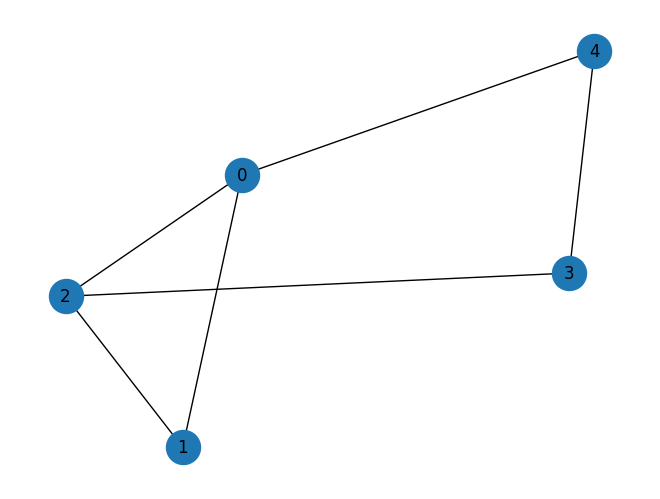

In [2]:
n = 5 # Number of vertices/nodes

graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
edge_list = [(0, 1, 1.0), (0, 2, 1.0), (0, 4, 1.0), (1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0)]
graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

## Map optimization problem to Hamiltonian

In [3]:
#check the edges
edge_0 = graph.edge_list()[0] # 0th edge
edge_0

(0, 1)

In [4]:
#check the weights
graph.get_edge_data(edge_0[0], edge_0[1]) # weight of 0th edge

1.0

In [5]:
def build_max_cut_paulis(graph):
    """
    Convert the graph to Pauli list.
    """
    pauli_list = []
    for edge in list(graph.edge_list()):
        # create Hamiltonian
        paulis = ["I"] * len(graph)
        
        # Set Z operators for every pair or nodes that are connected via an edge
        paulis[edge[0]], paulis[edge[1]] = "Z","Z"
        weight = graph.get_edge_data(edge[0], edge[1])
        
        # Join in reverse order from list of strings to a single string
        pauli_list.append(("".join(paulis)[::-1], weight))

    hamiltonian = SparsePauliOp.from_list(pauli_list)

    return hamiltonian


hamiltonian = build_max_cut_paulis(graph)

print("Cost Function Hamiltonian:", hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


## Create an ansatz suitable for the QAOA hamiltonian

In [6]:
ansatz = QAOAAnsatz(hamiltonian, reps = 1)
ansatz.measure_all()
ansatz.draw()

┌──────────────────┐ ░ ┌─┐            
   q_0: ┤0                 ├─░─┤M├────────────
        │                  │ ░ └╥┘┌─┐         
   q_1: ┤1                 ├─░──╫─┤M├─────────
        │                  │ ░  ║ └╥┘┌─┐      
   q_2: ┤2 QAOA(γ[0],β[0]) ├─░──╫──╫─┤M├──────
        │                  │ ░  ║  ║ └╥┘┌─┐   
   q_3: ┤3                 ├─░──╫──╫──╫─┤M├───
        │                  │ ░  ║  ║  ║ └╥┘┌─┐
   q_4: ┤4                 ├─░──╫──╫──╫──╫─┤M├
        └──────────────────┘ ░  ║  ║  ║  ║ └╥┘
meas: 5/════════════════════════╩══╩══╩══╩══╩═
                                0  1  2  3  4

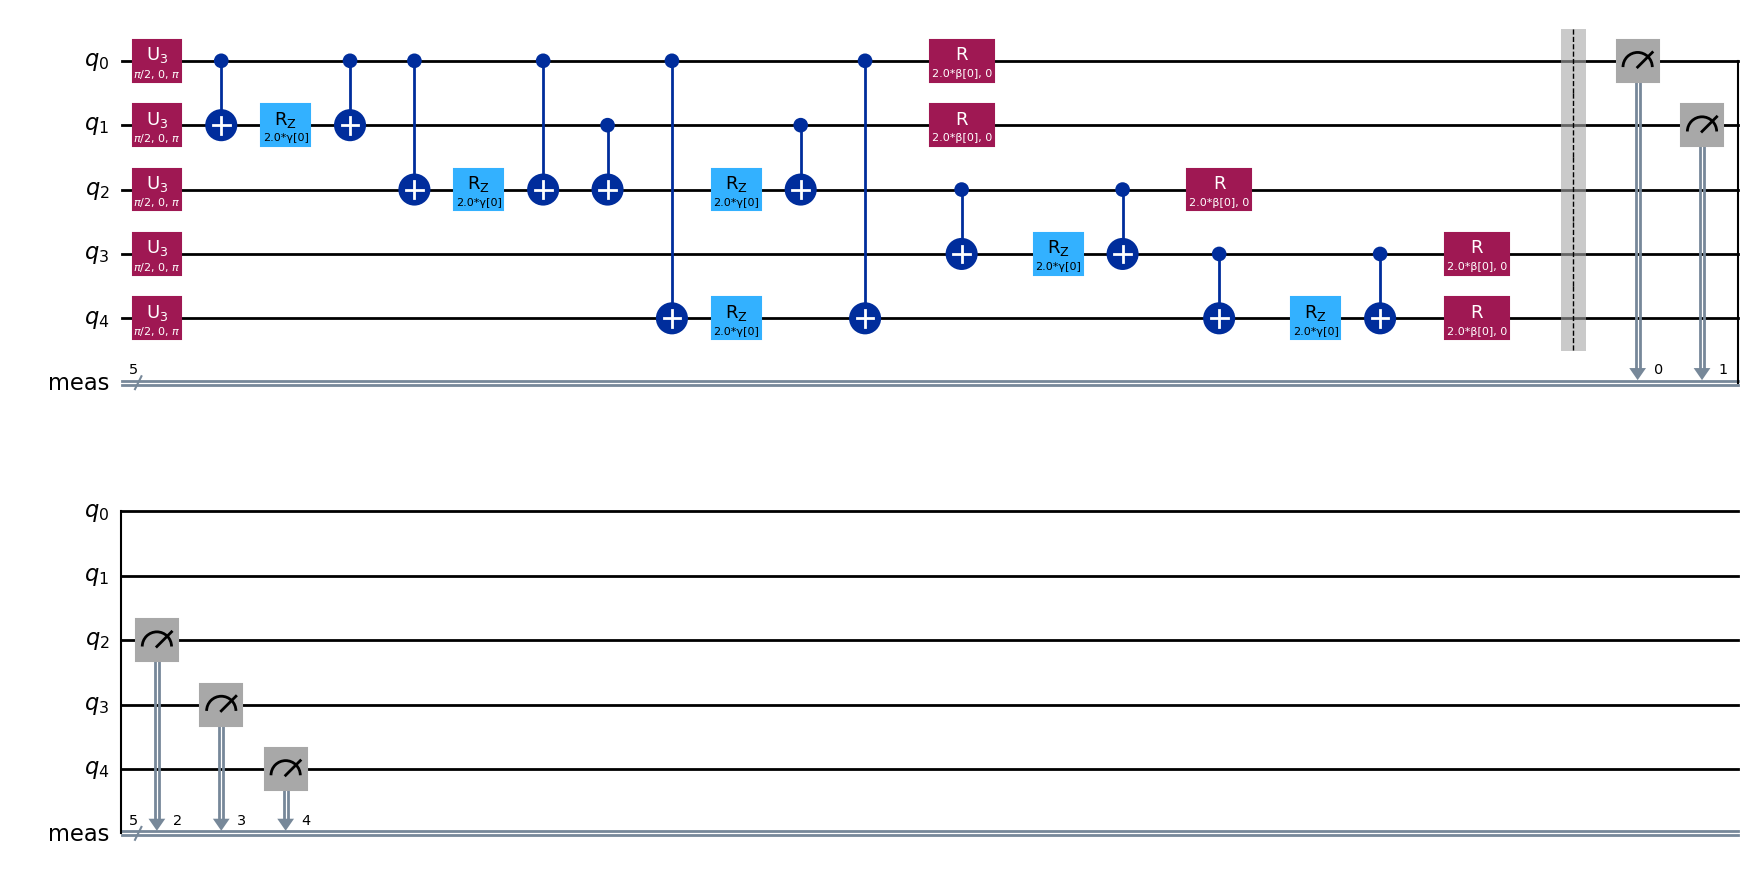

In [7]:
ansatz.decompose(reps=3).draw('mpl')

In [8]:
print(f"Number of parameters in ansatz: {ansatz.num_parameters}")
print(f"Number of qubits in ansatz: {ansatz.num_qubits}")

Number of parameters in ansatz: 2
Number of qubits in ansatz: 5


## Define cost function

In [9]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator):
    # Definie the cost function of this QAOA problem using a primitive unified block (pub).
    # the cost is represented by the expecation value of the hamiltonian
    # (exactly like in the VQE routine)
    pub = (ansatz, hamiltonian, params)
    result = estimator.run([pub]).result()
    cost = result[0].data.evs
    
    objective_func_vals.append(cost)

    return cost

## Optimize circuits for quantum hardware execution

In [10]:
def transpile_problem_hardware(backend,circuit,hamiltonian):
    pm = generate_preset_pass_manager(optimization_level=3,
                                    backend=backend)
    # mapping the virtual circuit to an ISA on physical qubits
    isa_circuit = pm.run(circuit)
    # transform the observable defined on virtual qubits to
    isa_hamiltonian = hamiltonian.apply_layout(isa_circuit.layout)
    return isa_circuit, isa_hamiltonian

In [11]:
sim_backend = AerSimulator()
#service = QiskitRuntimeService(channel='ibm_quantum')
#real_backend = service.least_busy(operational=True, simulator=False)
#real_backend

In [12]:
isa_ansatz, isa_hamiltonian = transpile_problem_hardware(sim_backend,ansatz,hamiltonian)

## Evaluate cost landscape (sim backend)

In [13]:
objective_func_vals = [] 
n_samples = 50
beta = np.linspace(0, np.pi, n_samples)
gamma = np.linspace(0, 2*np.pi, n_samples)
cost_landscape = np.zeros((n_samples,n_samples))

with Session(backend=sim_backend) as session:
    estimator = Estimator(mode=session)
    for i, beta_i in enumerate(beta):
        for j, gamma_j in enumerate(gamma):
            objective_func_vals = [] 
            params_ij = [beta_i,gamma_j]
            cost_landscape[i,j] = cost_func_estimator(params_ij, isa_ansatz, isa_hamiltonian, estimator)
            

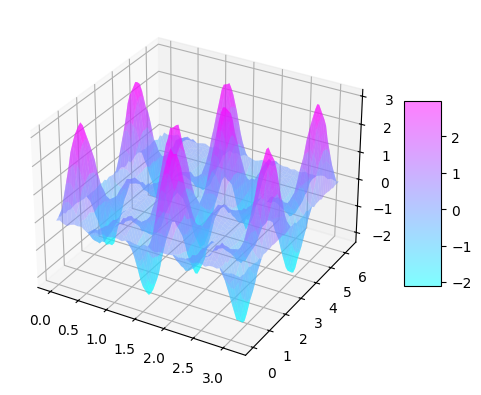

In [14]:
# Plot the cost landscape
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
beta_v, gamma_v = np.meshgrid(beta,gamma)
surf = ax.plot_surface(beta_v, gamma_v, cost_landscape, cmap=cm.cool,alpha=0.5)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

**Note:**
- The landscape is $\pi$ periodic, which is due to the periodic nature of the rotation gates in our ansatz.
- There are 4 minima within the parameter sweep $\beta \in [0,\pi], \gamma \in [0,\pi]$

## Minimize cost (real backend)

In [15]:
objective_func_vals = [] 
init_params = np.random.uniform(0,np.pi,size=ansatz.num_parameters)
init_params

array([0.26768254, 0.27752097])

In [16]:
#isa_ansatz, isa_hamiltonian = transpile_problem_hardware(real_backend,ansatz,hamiltonian)

In [17]:
with Session(backend=sim_backend) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 1000

    # Set simple error suppression/mitigation options
    #estimator.options.dynamical_decoupling.enable = True
    #estimator.options.dynamical_decoupling.sequence_type = "XY4"
    #estimator.options.twirling.enable_gates = True
    #estimator.options.twirling.num_randomizations = "auto"

    result = minimize(
        cost_func_estimator,
        init_params,
        args=(isa_ansatz, isa_hamiltonian, estimator),
        method="COBYLA",
        tol=1e-3,
    )
    print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.2797202797202796
       x: [ 1.186e+00  3.390e-01]
    nfev: 24
   maxcv: 0.0


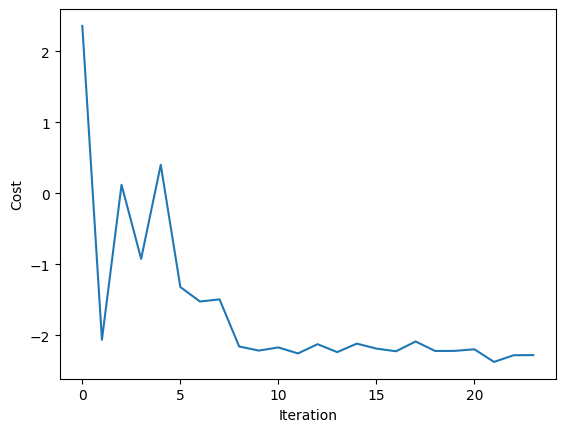

In [18]:
plt.figure()
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

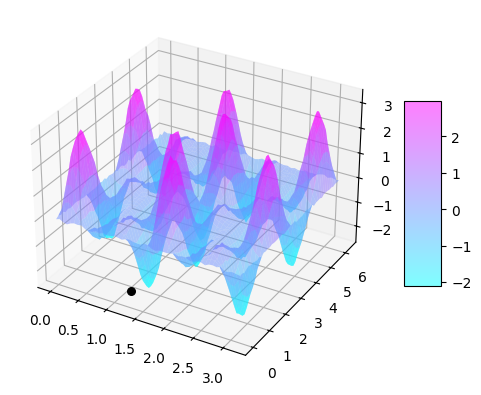

In [19]:
# Plot the cost landscape
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
beta_v, gamma_v = np.meshgrid(beta,gamma)
surf = ax.plot_surface(beta_v, gamma_v, cost_landscape, cmap=cm.cool,alpha=0.5)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.scatter(result.x[0],result.x[1],result.fun,color='black',s=30)

plt.show()

## Sample solution from optimized circuit

In [20]:
# Assign the parameters to the 'isa_ansatz' that where used to evaluate the smalles observable
optimized_circuit = isa_ansatz.assign_parameters(result.x)

In [21]:
sampler = Sampler(mode=sim_backend)
sampler.options.default_shots = 500000

# Set simple error suppression/mitigation options
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"

pub= (optimized_circuit, )
job = sampler.run([pub])

/Users/adri/Documents/FHTW/QE Semeser 1/Quantum Programming Lab/qiskit_env/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:234: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


## Post process results

In [22]:
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}

print(final_distribution_bin)
most_likely_bitstring = max(final_distribution_bin, key=final_distribution_bin.get)
most_likely_bitlist = [int(ele) for ele in [*most_likely_bitstring]][::-1]
print(f"Most likely bitstring: {most_likely_bitlist}")

{'11010': 0.069184, '10010': 0.045784, '01101': 0.04598, '01010': 0.045556, '00101': 0.068442, '10001': 0.029144, '01110': 0.028732, '10100': 0.10572, '01001': 0.10525, '01011': 0.105534, '10000': 0.005564, '01000': 0.005666, '00000': 0.00572, '10110': 0.10613, '00011': 0.01435, '01111': 0.005842, '11011': 0.009226, '11001': 0.014176, '01100': 0.029076, '00001': 0.009376, '10011': 0.029154, '11100': 0.013796, '11111': 0.005864, '10111': 0.00565, '10101': 0.045754, '11110': 0.009118, '11000': 0.003406, '00100': 0.008886, '00110': 0.014052, '00111': 0.003456, '11101': 0.003122, '00010': 0.00329}
Most likely bitstring: [0, 1, 1, 0, 1]


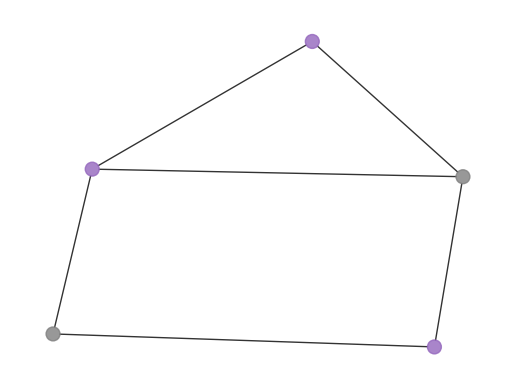

In [23]:
def plot_result(graph, x):
    plt.figure()
    colors = ["tab:grey" if i == 0 else "tab:purple" for i in x]
    pos, default_axes = rx.spring_layout(graph), plt.axes(frameon=True)
    rx.visualization.mpl_draw(graph, node_color=colors, node_size=100, alpha=0.8, pos=pos)


plot_result(graph, most_likely_bitlist)

In [24]:
# we find the maximum probability (our solution) 
# --> reverse bitstring (because minima) 